In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet
!pip install gower --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

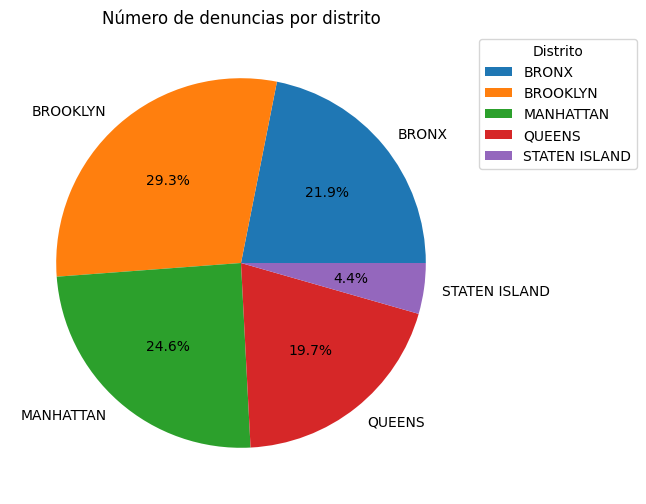

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## BRONX

In [ ]:
df_bronx = df[df.distrito == 'BRONX'].copy()
df_bronx.reset_index(inplace = True, drop = True)
df_bronx['direccion_suceso'] = df_bronx['direccion_suceso'].astype('object')

In [ ]:
df_bronx.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa','delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [ ]:
df_bronx['latitud'] = df_bronx.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_bronx['longitud'] = df_bronx.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_bronx.drop(columns= ['geoespacial'], inplace = True)
df_bronx.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Noche,Policia,45-64,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,martes,invierno,marzo,40.873671,-73.908014
1,Noche,Policia,25-44,BLACK,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,diversion y turismo,miercoles,otono,octubre,40.853653,-73.906892
2,Noche,Policia,45-64,WHITE,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,septiembre,40.826170,-73.916831
3,Tarde,Policia,UNKNOWN,UNKNOWN,Desconocido,45-64,BLACK,Femenino,incidentes_menores,lugares publicos,domingo,invierno,marzo,40.827049,-73.894994
4,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,25-44,ASIAN / PACIFIC ISLANDER,Femenino,incidentes_menores,lugares publicos,miercoles,primavera,junio,40.882615,-73.851948


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_bronx.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_bronx_ready = pd.concat([df_bronx.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_bronx_ready_sample =df_bronx_ready.sample(frac = 0.2, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y, adicional, con reducción de dimensionalidad aplicando KMeans.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

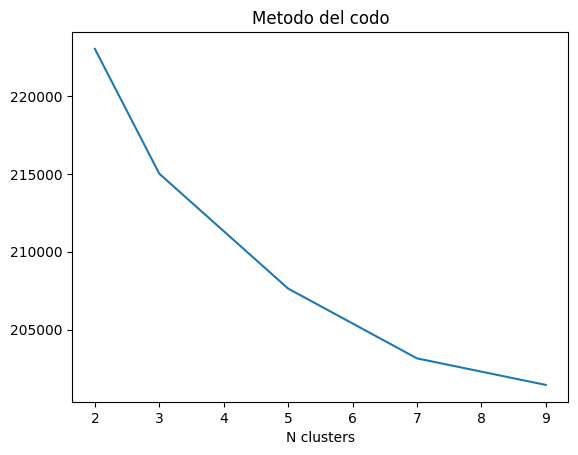

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_bronx_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


### Cohesión y Separabilidad con KMeans y n clusters
- **Calinski-Harabasz:** cuanto mayor sea el valor del índice  se considera que el clustering es mejor.

- **Silhoutte Score:** Un valor cercano a 1 indica que las muestras están bien asignadas a sus clusters y están alejadas de los otros clusters vecinos. Un valor cercano a 0 indica que las muestras están en o cerca del límite de decisión entre dos clusters vecinos. Un valor cercano a -1 indica que las muestras pueden haber sido asignadas incorrectamente a sus clusters y que están más cerca de los otros clusters vecinos.

In [ ]:
from sklearn import metrics
sample = df_bronx_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,8880.606503,0.093576
1,KMeans,3,7835.419454,0.102561
2,KMeans,5,5382.366464,0.074459
3,KMeans,7,4221.401989,0.064865
4,KMeans,9,3526.144750,0.068789


In [ ]:
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
dummies = pd.get_dummies(df_bronx_ready)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
kmeans = KMeansDask(n_clusters=3, random_state=1234)
kmeans.fit(X)


KMeans(n_clusters=3, random_state=1234)

### Centroides con KMeans y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [ ]:
centroides_bronx = pd.DataFrame(centroids, columns = pd.get_dummies(df_bronx_ready_sample).columns.tolist())
centroides_bronx.reset_index(inplace = True, drop = False)
centroides_bronx.rename(columns = {'index':'cluster'}, inplace =True)
centroides_bronx

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.786729,0.585478,0.165833,0.210053,0.300768,0.323346,0.000022,0.005003,0.871880,0.012716,0.110379,0.436899,0.139222,0.062374,0.361506,0.002893,0.012727,0.594065,0.043553,0.346762,0.010314,0.269821,0.719865,0.484248,0.222455,0.087321,0.205976,0.004634,0.025945,0.493135,0.047388,0.428899,0.642346,0.357412,0.000242,0.003559,0.315154,0.354134,0.130539,0.171976,0.024639,0.022402,0.054842,0.853302,0.021537,0.047917,0.146979,0.138401,0.144357,0.141172,0.141299,0.142582,0.145211,0.230157,0.249017,0.252388,0.268438,0.081531,0.091173,0.156786,0.080104,0.088693,0.088958,0.071575,0.081900,0.085806,0.084903,0.088572
1,1,0.793163,0.588676,0.156468,0.200438,0.332192,0.310903,0.000008,0.004056,0.926384,0.011300,0.058252,0.002352,0.001483,0.001713,0.994453,0.000098,0.000459,0.013479,0.974852,0.011111,0.907521,0.034006,0.058474,0.465650,0.283625,0.047813,0.202912,0.006736,0.034268,0.451048,0.075780,0.432169,0.447205,0.550771,0.002024,0.001442,0.091742,0.104279,0.565471,0.230412,0.006654,0.023984,0.066709,0.828316,0.032687,0.048305,0.136318,0.139235,0.147684,0.142923,0.142071,0.141366,0.150404,0.230518,0.258895,0.243785,0.266802,0.077894,0.088612,0.166358,0.077984,0.086801,0.085629,0.068938,0.080262,0.088735,0.087399,0.091390
2,2,0.780012,0.580529,0.152670,0.158209,0.326306,0.362815,0.000020,0.043967,0.819773,0.041547,0.094693,0.320894,0.123362,0.031896,0.523848,0.001151,0.007723,0.417319,0.305488,0.268319,0.284965,0.115186,0.599848,0.000059,0.000315,0.000118,0.999508,0.000098,0.000679,0.001623,0.996202,0.001397,0.016017,0.027931,0.956052,0.317727,0.022303,0.031846,0.361340,0.239335,0.027449,0.062188,0.246163,0.580103,0.046063,0.065483,0.117626,0.152995,0.117272,0.146570,0.159409,0.145478,0.160649,0.239257,0.244687,0.258628,0.257428,0.085121,0.087403,0.149128,0.087915,0.081225,0.090079,0.077683,0.083428,0.085770,0.083448,0.088800


In [ ]:
bronx_kmeans_sin_reduccion = df_bronx_ready.copy()
bronx_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

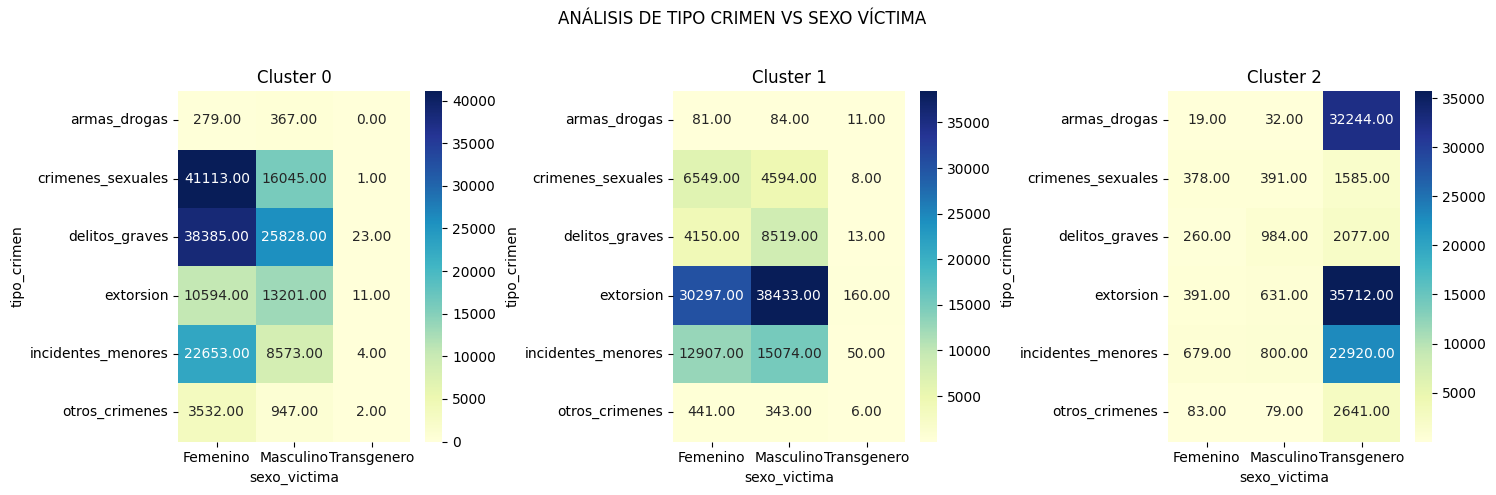

In [ ]:
bronx_cluster0 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==0]
bronx_cluster1 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==1]
bronx_cluster2 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster0['tipo_crimen'], bronx_cluster0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster1['tipo_crimen'], bronx_cluster1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster2['tipo_crimen'], bronx_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

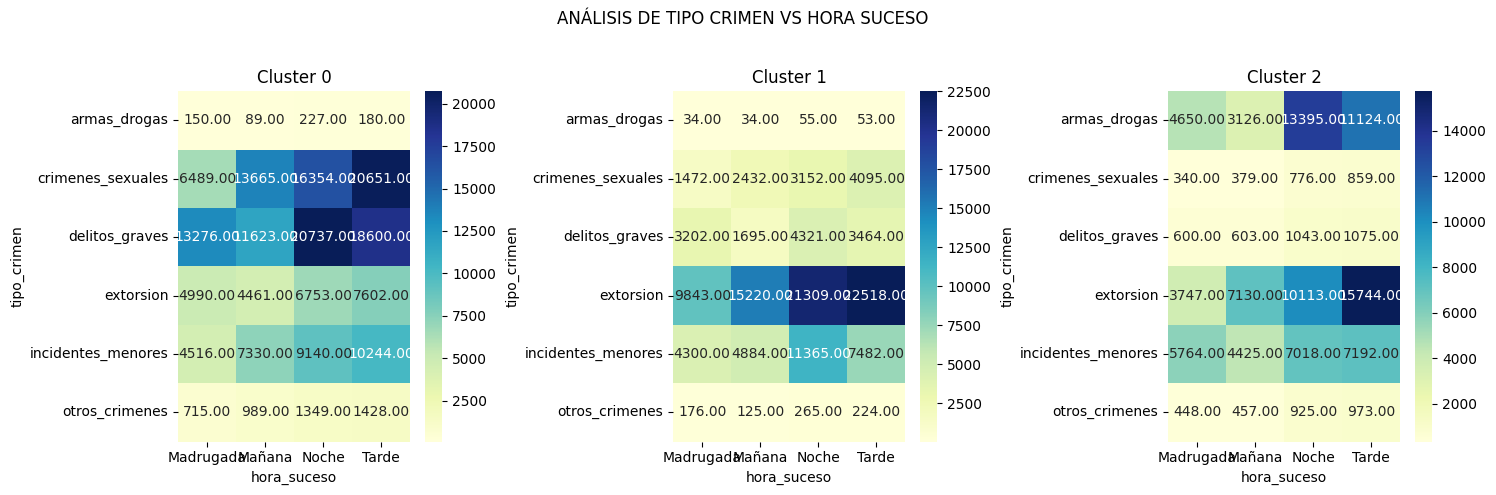

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster0['tipo_crimen'], bronx_cluster0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster1['tipo_crimen'], bronx_cluster1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster2['tipo_crimen'], bronx_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

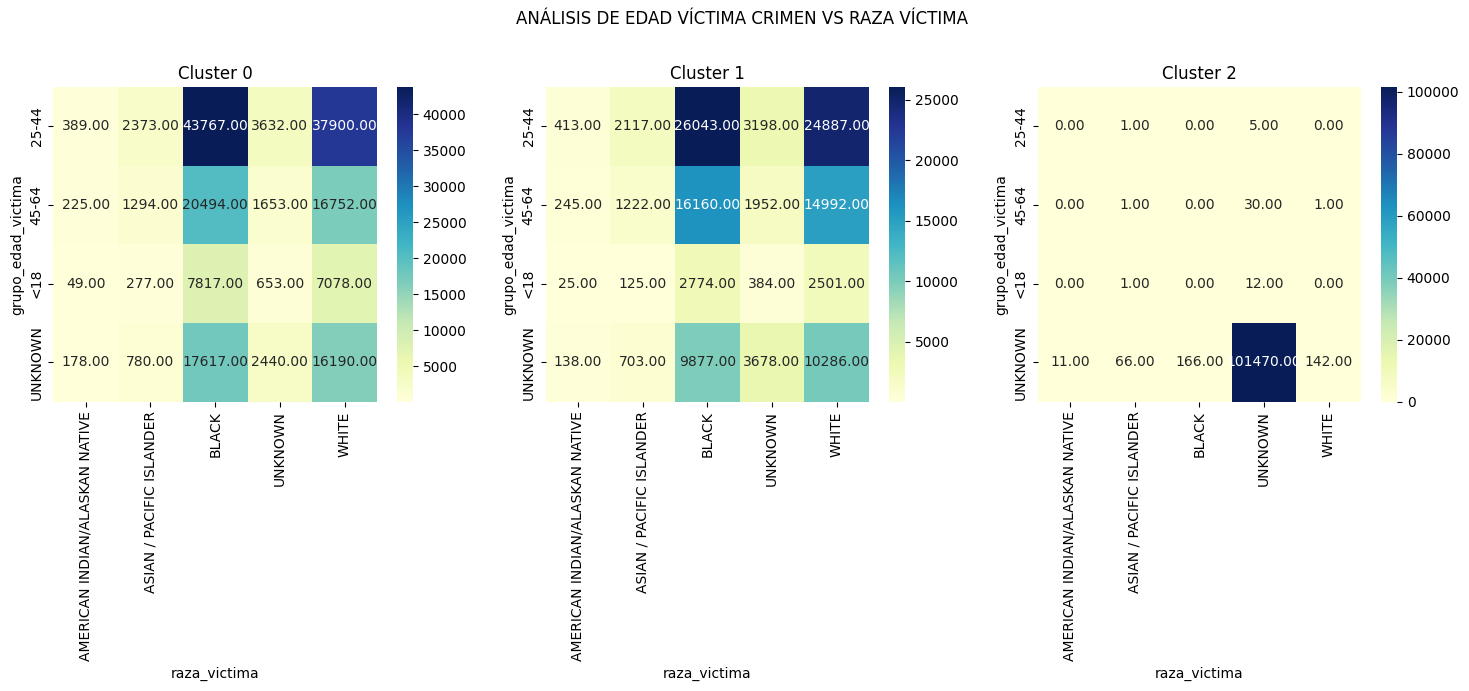

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster0['grupo_edad_victima'], bronx_cluster0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster1['grupo_edad_victima'], bronx_cluster1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster2['grupo_edad_victima'], bronx_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in bronx_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = bronx_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = bronx_kmeans_sin_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,30136,16.6%
1,0,Mañana,38157,21.0%
2,0,Noche,54560,30.1%
3,0,Tarde,58705,32.3%
4,1,Madrugada,19027,15.6%
5,1,Mañana,24390,20.0%
6,1,Noche,40467,33.2%
7,1,Tarde,37836,31.1%
8,2,Madrugada,15549,15.3%
9,2,Mañana,16120,15.8%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,4,0.0%
1,0,Otras,883,0.5%
2,0,Policia,158285,87.2%
3,0,Transito,2313,1.3%
4,0,Vivienda,20073,11.1%
5,1,Externas,1,0.0%
6,1,Otras,495,0.4%
7,1,Policia,112812,92.7%
8,1,Transito,1373,1.1%
9,1,Vivienda,7039,5.8%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,79153,43.6%
1,0,45-64,25228,13.9%
2,0,<18,11313,6.2%
3,0,UNKNOWN,65864,36.3%
4,1,25-44,282,0.2%
5,1,45-64,175,0.1%
6,1,<18,203,0.2%
7,1,UNKNOWN,121060,99.5%
8,2,25-44,32767,32.2%
9,2,45-64,12586,12.4%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,528,0.3%
1,0,ASIAN / PACIFIC ISLANDER,2322,1.3%
2,0,BLACK,107756,59.4%
3,0,UNKNOWN,8031,4.4%
4,0,WHITE,62921,34.7%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,9,0.0%
6,1,ASIAN / PACIFIC ISLANDER,42,0.0%
7,1,BLACK,1636,1.3%
8,1,UNKNOWN,118797,97.6%
9,1,WHITE,1236,1.0%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,1907,1.1%
1,0,Femenino,49039,27.0%
2,0,Masculino,130612,71.9%
3,1,Desconocido,110713,91.0%
4,1,Femenino,4020,3.3%
5,1,Masculino,6987,5.7%
6,2,Desconocido,28969,28.4%
7,2,Femenino,11772,11.6%
8,2,Masculino,61165,60.0%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,88061,48.5%
1,0,45-64,40418,22.3%
2,0,<18,15874,8.7%
3,0,UNKNOWN,37205,20.5%
4,1,25-44,56658,46.5%
5,1,45-64,34571,28.4%
6,1,<18,5809,4.8%
7,1,UNKNOWN,24682,20.3%
8,2,25-44,6,0.0%
9,2,45-64,32,0.0%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,841,0.5%
1,0,ASIAN / PACIFIC ISLANDER,4724,2.6%
2,0,BLACK,89695,49.4%
3,0,UNKNOWN,8378,4.6%
4,0,WHITE,77920,42.9%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,821,0.7%
6,1,ASIAN / PACIFIC ISLANDER,4167,3.4%
7,1,BLACK,54854,45.1%
8,1,UNKNOWN,9212,7.6%
9,1,WHITE,52666,43.3%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,116556,64.2%
1,0,Masculino,64961,35.8%
2,0,Transgenero,41,0.0%
3,1,Femenino,54425,44.7%
4,1,Masculino,67047,55.1%
5,1,Transgenero,248,0.2%
6,2,Femenino,1810,1.8%
7,2,Masculino,2917,2.9%
8,2,Transgenero,97179,95.4%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,646,0.4%
1,0,crimenes_sexuales,57159,31.5%
2,0,delitos_graves,64236,35.4%
3,0,extorsion,23806,13.1%
4,0,incidentes_menores,31230,17.2%
5,0,otros_crimenes,4481,2.5%
6,1,armas_drogas,176,0.1%
7,1,crimenes_sexuales,11151,9.2%
8,1,delitos_graves,12682,10.4%
9,1,extorsion,68890,56.6%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,4046,2.2%
1,0,diversion y turismo,9966,5.5%
2,0,lugares publicos,154927,85.3%
3,0,lugares solitarios,3917,2.2%
4,0,necesidades diarias,8702,4.8%
5,1,Otros,2921,2.4%
6,1,diversion y turismo,8125,6.7%
7,1,lugares publicos,100811,82.8%
8,1,lugares solitarios,3980,3.3%
9,1,necesidades diarias,5883,4.8%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,26699,14.7%
1,0,jueves,25108,13.8%
2,0,lunes,26223,14.4%
3,0,martes,25617,14.1%
4,0,miercoles,25648,14.1%
5,0,sabado,25904,14.3%
6,0,viernes,26359,14.5%
7,1,domingo,16592,13.6%
8,1,jueves,16953,13.9%
9,1,lunes,17969,14.8%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,41776,23.0%
1,0,otono,45196,24.9%
2,0,primavera,45787,25.2%
3,0,verano,48799,26.9%
4,1,invierno,28072,23.1%
5,1,otono,31528,25.9%
6,1,primavera,29696,24.4%
7,1,verano,32424,26.6%
8,2,invierno,24377,23.9%
9,2,otono,24939,24.5%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,14785,8.1%
1,0,agosto,16571,9.1%
2,0,diciembre,28465,15.7%
3,0,febrero,14535,8.0%
4,0,julio,16128,8.9%
5,0,junio,16143,8.9%
6,0,marzo,12988,7.2%
7,0,mayo,14859,8.2%
8,0,noviembre,15573,8.6%
9,0,octubre,15411,8.5%


### 1.2 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_bronx_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.9763961330391382

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,-1.452686,-1.208806,0.309023,-0.108300,-0.293856,-0.620233,-0.570559,-0.700228,0.612912,-0.186485,0.209470,-0.361985,-0.295511,0.564572,0.606266,0.884253,-0.158036,0.100213,0.250829,-0.470089,-0.433042,0.458533,0.056433,-0.088600,-0.044801,0.331171,0.274214,0.096196,0.034755,0.123475,0.511245,0.319026,0.102076,0.559844,0.287494,0.325191,-0.066079,-0.055633,0.190312,-0.061466
1,-0.653150,0.481029,-0.213537,-1.007701,-1.171720,-0.277990,0.652746,-0.332595,0.177425,0.015785,-0.251650,-0.465288,-0.151825,0.948597,-0.527530,-0.173055,0.116808,0.006373,0.059927,0.108581,-0.021945,0.485157,0.082298,0.144456,0.880751,-0.632996,-0.274386,-0.186819,0.004565,-0.058062,-0.054486,0.053759,-0.309594,-0.488259,-0.325108,0.754683,-0.097688,0.055328,-0.187561,-0.172179
2,1.567502,-0.058314,-0.467475,-0.803161,0.358326,0.062649,1.278123,0.071361,0.562417,-0.452812,-0.046784,-0.539690,-0.162416,0.102575,0.070256,0.044349,-0.090212,-0.264002,0.107632,-0.240008,-0.129447,-0.817724,-0.087568,-0.221476,0.277799,-0.041243,0.361592,-0.034657,0.692030,0.426531,-0.038830,-0.001838,-0.206431,-0.141939,-0.017487,-0.261493,-0.138198,-0.042695,-0.398480,0.257749
3,-0.650339,-1.562212,0.527853,-0.165547,-0.693458,-0.349138,0.279966,-0.692584,1.130724,0.470691,-0.572033,0.336230,-0.560602,-0.391942,0.329326,0.105417,0.125186,0.031383,0.205056,0.140460,-0.066869,-0.802434,-0.184431,-0.191713,0.451897,0.352170,0.267886,0.374186,-0.040913,-0.107678,-0.451462,-0.398244,0.469007,0.006861,-0.021212,0.261355,-0.008960,-0.015442,0.123453,-0.060177
4,1.362448,0.360630,0.375964,0.885219,-0.147602,1.100169,0.257872,-0.024160,0.418174,-0.523667,-0.164947,-0.182638,0.713387,0.104431,-0.168959,-0.193599,0.066145,0.116187,0.184105,0.340534,0.060639,0.070144,-0.782116,0.132508,-0.262429,-0.125832,-0.033824,0.028756,-0.150852,0.072693,0.560853,-0.225689,0.173867,-0.328924,-0.176662,-0.083763,-0.056743,-0.031910,-0.030425,-0.040780


Según el método del codo, cuántos cluster serían una elección óptima?

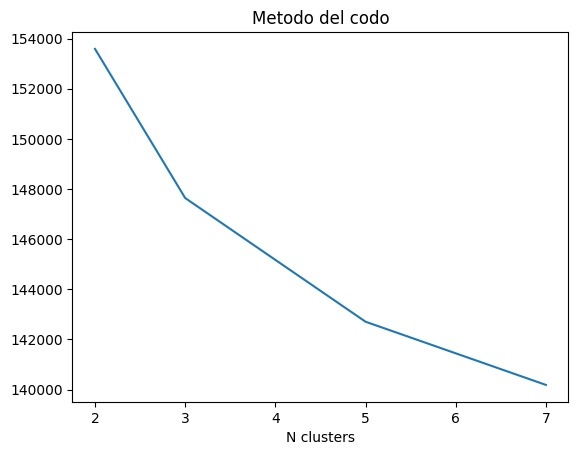

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []
sample = X_PCA_ok.sample(frac = 0.7)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,2743.171438,0.096208
1,KMeans_PCA,3,2437.712752,0.105311
2,KMeans_PCA,5,1664.171340,0.075478
3,KMeans_PCA,7,1230.320330,0.069634
4,KMeans_PCA,9,1106.775308,0.063666


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [ ]:
centroides_brooklyn_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_brooklyn_pca.reset_index(inplace = True, drop = False)
centroides_brooklyn_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,1.254806,0.108500,0.008445,0.001929,0.004600,-0.008491,-0.014681,0.008194,0.014694,-0.023419,-0.042742,0.014729,0.036017,0.087718,-0.042664,0.008805,-0.029736,0.007575,-0.004692,-0.043164,0.002330,0.004361,-0.001867,0.013993,0.005895,0.003598,-0.001661,-0.036682,0.002006,0.000189,-0.000266,-0.003132,0.002502,-0.006902,-0.006319,-0.008985,-0.012695,0.015196,-0.019261,0.023409
1,1,-0.537255,0.691814,-0.014334,-0.034294,-0.029274,0.020629,0.039532,-0.006438,-0.018819,0.071336,0.027033,-0.006488,-0.017910,-0.059290,0.014465,0.009035,0.007852,-0.002808,0.003441,0.021645,-0.000871,0.009692,-0.000698,0.029135,0.020853,0.001123,0.028536,-0.000367,-0.000316,0.000176,0.001455,0.000727,0.001973,0.004761,0.002260,0.002346,0.018591,-0.010073,0.004905,0.011686
2,2,-0.540919,-1.379271,0.015706,0.059575,0.047299,-0.027010,-0.053677,0.001755,0.016277,-0.100561,0.002665,-0.006022,-0.011033,0.001412,0.025254,-0.026908,0.021625,-0.004050,-0.000563,0.012897,-0.001234,-0.022744,0.003507,-0.069431,-0.044734,-0.006359,-0.049505,0.044823,-0.001845,-0.000545,-0.002305,0.002458,-0.006573,-0.000284,0.003529,0.006582,-0.018272,-0.000113,0.014334,-0.049273


In [ ]:
bronx_kmeans_con_reduccion = df_bronx_ready_sample.copy()
bronx_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

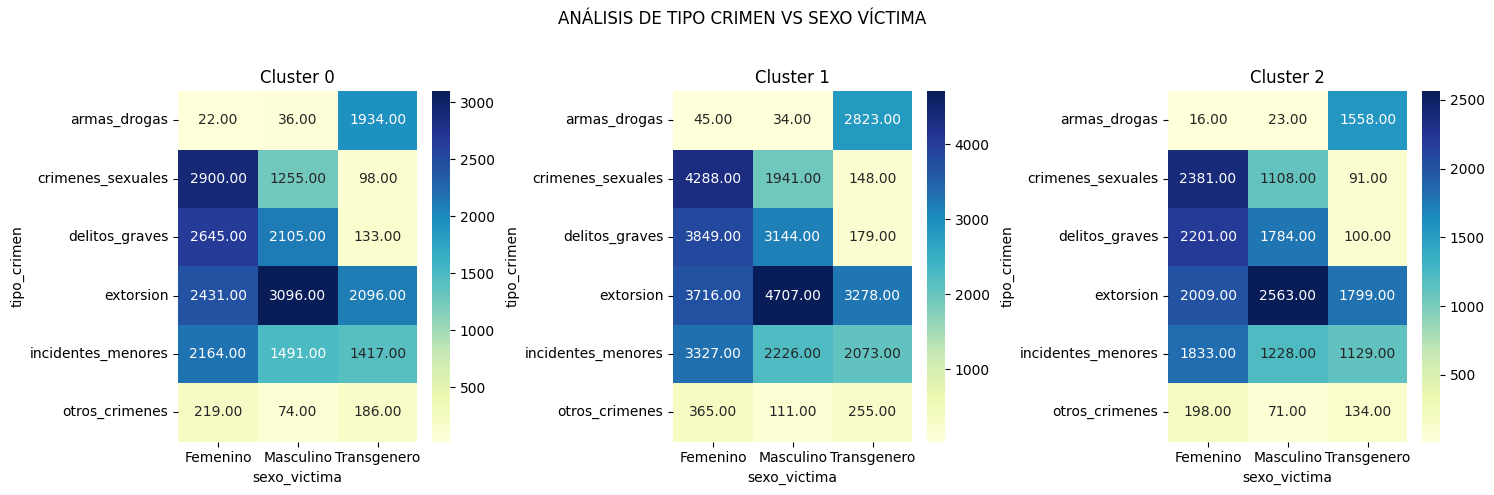

In [ ]:
bronx_cluster_pca0 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==0]
bronx_cluster_pca1 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==1]
bronx_cluster_pca2 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_pca0['tipo_crimen'], bronx_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster_pca1['tipo_crimen'], bronx_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster_pca2['tipo_crimen'], bronx_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

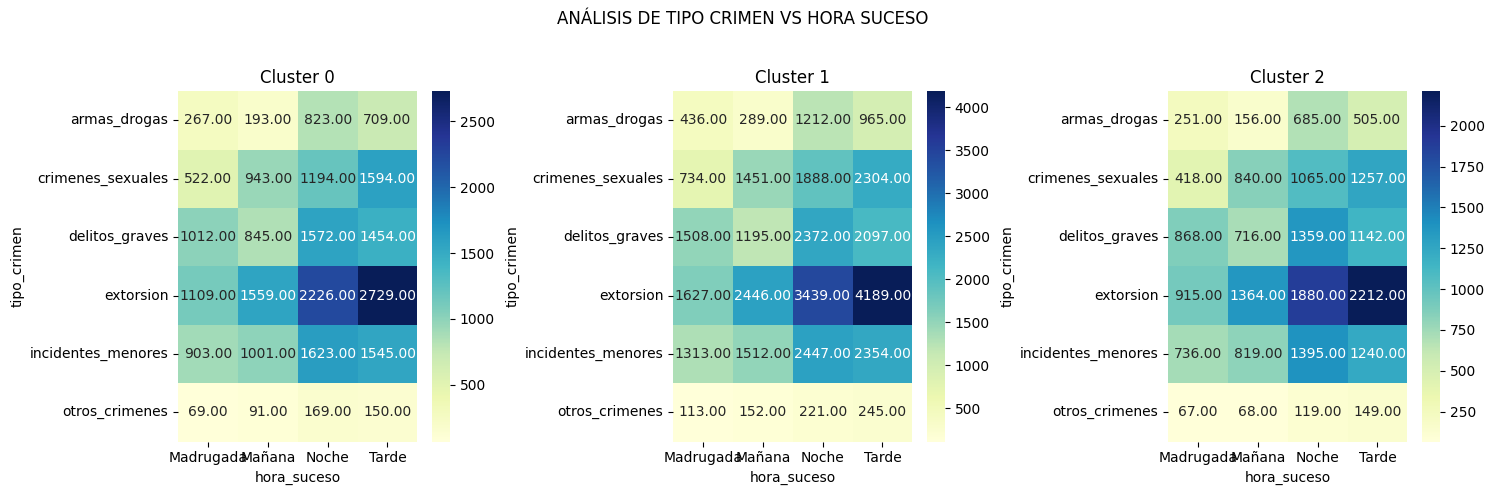

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster_pca0['tipo_crimen'], bronx_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster_pca1['tipo_crimen'], bronx_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster_pca2['tipo_crimen'], bronx_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

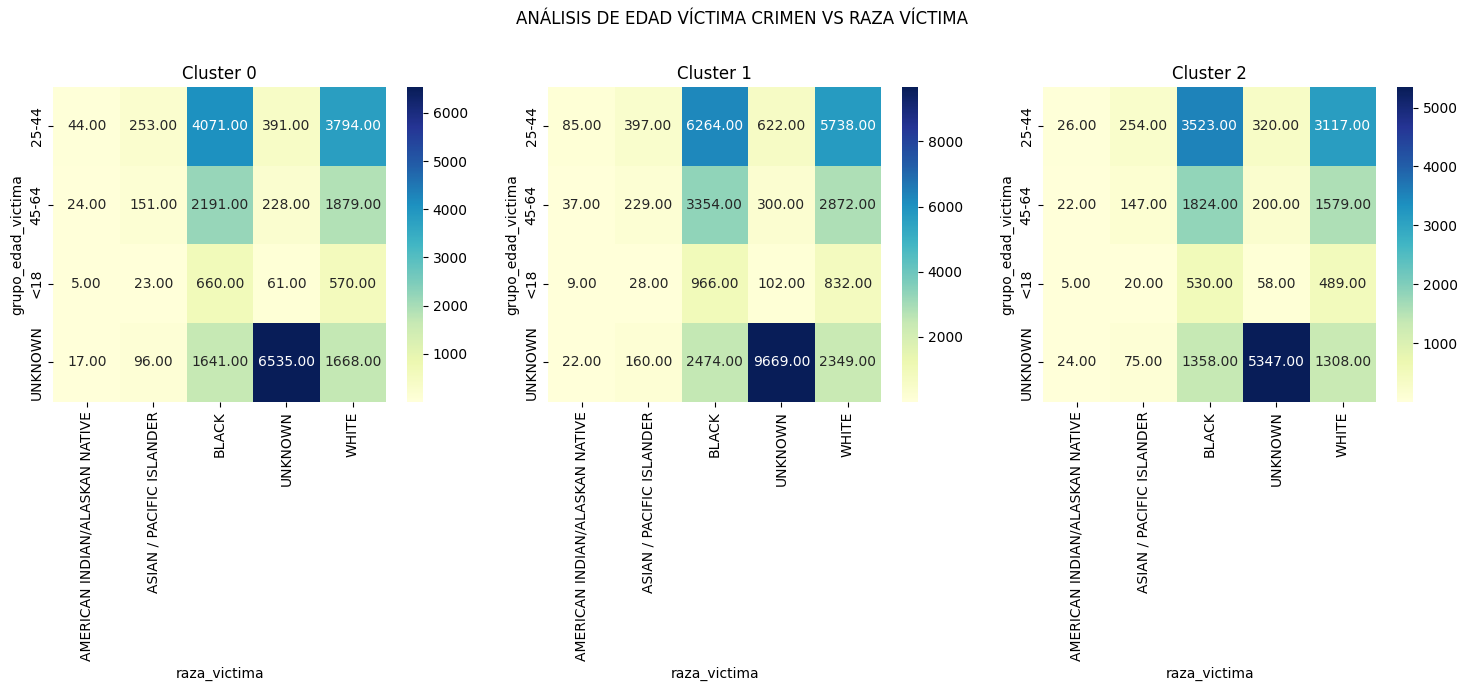

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_pca0['grupo_edad_victima'], bronx_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster_pca1['grupo_edad_victima'], bronx_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster_pca2['grupo_edad_victima'], bronx_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in bronx_kmeans_con_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = bronx_kmeans_con_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = bronx_kmeans_con_reduccion.groupby('clusters').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'clusters')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,clusters,hora_suceso,casos,participacion
0,0,Madrugada,3882,16.0%
1,0,Mañana,4632,19.1%
2,0,Noche,7607,31.3%
3,0,Tarde,8181,33.7%
4,1,Madrugada,5731,15.7%
5,1,Mañana,7045,19.3%
6,1,Noche,11579,31.7%
7,1,Tarde,12154,33.3%
8,2,Madrugada,3255,16.1%
9,2,Mañana,3963,19.6%




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos,participacion
0,0,Externas,1,0.0%
1,0,Otras,377,1.6%
2,0,Policia,21188,87.2%
3,0,Transito,480,2.0%
4,0,Vivienda,2256,9.3%
5,1,Externas,1,0.0%
6,1,Otras,551,1.5%
7,1,Policia,32051,87.8%
8,1,Transito,685,1.9%
9,1,Vivienda,3221,8.8%




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos,participacion
0,0,25-44,6720,27.7%
1,0,45-64,2319,9.5%
2,0,<18,915,3.8%
3,0,UNKNOWN,14348,59.0%
4,1,25-44,10080,27.6%
5,1,45-64,3494,9.6%
6,1,<18,1348,3.7%
7,1,UNKNOWN,21587,59.1%
8,2,25-44,5590,27.6%
9,2,45-64,1856,9.2%




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,36,0.1%
1,0,ASIAN / PACIFIC ISLANDER,204,0.8%
2,0,BLACK,9104,37.5%
3,0,UNKNOWN,9351,38.5%
4,0,WHITE,5607,23.1%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,60,0.2%
6,1,ASIAN / PACIFIC ISLANDER,299,0.8%
7,1,BLACK,13607,37.3%
8,1,UNKNOWN,14202,38.9%
9,1,WHITE,8341,22.8%




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos,participacion
0,0,Desconocido,8454,34.8%
1,0,Femenino,3870,15.9%
2,0,Masculino,11978,49.3%
3,1,Desconocido,12663,34.7%
4,1,Femenino,5896,16.1%
5,1,Masculino,17950,49.2%
6,2,Desconocido,7043,34.8%
7,2,Femenino,3259,16.1%
8,2,Masculino,9924,49.1%




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos,participacion
0,0,25-44,8553,35.2%
1,0,45-64,4473,18.4%
2,0,<18,1319,5.4%
3,0,UNKNOWN,9957,41.0%
4,1,25-44,13106,35.9%
5,1,45-64,6792,18.6%
6,1,<18,1937,5.3%
7,1,UNKNOWN,14674,40.2%
8,2,25-44,7240,35.8%
9,2,45-64,3772,18.6%




Variable raza_victima:


,clusters,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,90,0.4%
1,0,ASIAN / PACIFIC ISLANDER,523,2.2%
2,0,BLACK,8563,35.2%
3,0,UNKNOWN,7215,29.7%
4,0,WHITE,7911,32.6%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,153,0.4%
6,1,ASIAN / PACIFIC ISLANDER,814,2.2%
7,1,BLACK,13058,35.8%
8,1,UNKNOWN,10693,29.3%
9,1,WHITE,11791,32.3%




Variable sexo_victima:


,clusters,sexo_victima,casos,participacion
0,0,Femenino,10381,42.7%
1,0,Masculino,8057,33.2%
2,0,Transgenero,5864,24.1%
3,1,Femenino,15590,42.7%
4,1,Masculino,12163,33.3%
5,1,Transgenero,8756,24.0%
6,2,Femenino,8638,42.7%
7,2,Masculino,6777,33.5%
8,2,Transgenero,4811,23.8%




Variable tipo_crimen:


,clusters,tipo_crimen,casos,participacion
0,0,armas_drogas,1992,8.2%
1,0,crimenes_sexuales,4253,17.5%
2,0,delitos_graves,4883,20.1%
3,0,extorsion,7623,31.4%
4,0,incidentes_menores,5072,20.9%
5,0,otros_crimenes,479,2.0%
6,1,armas_drogas,2902,7.9%
7,1,crimenes_sexuales,6377,17.5%
8,1,delitos_graves,7172,19.6%
9,1,extorsion,11701,32.0%




Variable lugar:


,clusters,lugar,casos,participacion
0,0,Otros,812,3.3%
1,0,diversion y turismo,2563,10.5%
2,0,lugares publicos,18869,77.6%
3,0,lugares solitarios,751,3.1%
4,0,necesidades diarias,1307,5.4%
5,1,Otros,1223,3.3%
6,1,diversion y turismo,3898,10.7%
7,1,lugares publicos,28357,77.7%
8,1,lugares solitarios,1088,3.0%
9,1,necesidades diarias,1943,5.3%




Variable dia_suceso:


,clusters,dia_suceso,casos,participacion
0,0,domingo,3349,13.8%
1,0,jueves,3465,14.3%
2,0,lunes,3339,13.7%
3,0,martes,3496,14.4%
4,0,miercoles,3557,14.6%
5,0,sabado,3450,14.2%
6,0,viernes,3646,15.0%
7,1,domingo,4899,13.4%
8,1,jueves,5244,14.4%
9,1,lunes,5087,13.9%




Variable estacion_suceso:


,clusters,estacion_suceso,casos,participacion
0,0,invierno,5536,22.8%
1,0,otono,6152,25.3%
2,0,primavera,6239,25.7%
3,0,verano,6375,26.2%
4,1,invierno,8526,23.4%
5,1,otono,9168,25.1%
6,1,primavera,9117,25.0%
7,1,verano,9698,26.6%
8,2,invierno,4661,23.0%
9,2,otono,4956,24.5%




Variable mes_suceso:


,clusters,mes_suceso,casos,participacion
0,0,abril,2092,8.6%
1,0,agosto,2160,8.9%
2,0,diciembre,3851,15.8%
3,0,febrero,1903,7.8%
4,0,julio,2104,8.7%
5,0,junio,2164,8.9%
6,0,marzo,1709,7.0%
7,0,mayo,1983,8.2%
8,0,noviembre,2140,8.8%
9,0,octubre,2085,8.6%


### **3. Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_bronx_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_bronx_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


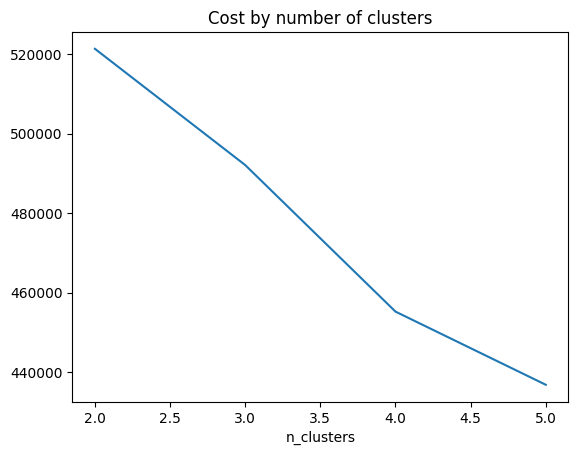

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_bronx_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
sample = categoricas_bronx_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)
metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,9368.263846,0.054393
1,KModes,3,8458.086568,0.042282
2,KModes,4,4023.671543,-0.004884
3,KModes,5,5067.537325,0.005428


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)

In [ ]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_bronx_encoded2 = categoricas_bronx_encoded.copy()
categoricas_bronx_encoded2['labels'] = kmodes.fit_predict(categoricas_bronx_encoded2)
categoricas_bronx['labels']  = categoricas_bronx_encoded2['labels'] 
categoricas_bronx.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Noche,45-64,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,martes,invierno,marzo,2
1,Noche,25-44,BLACK,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,diversion y turismo,miercoles,otono,octubre,2
2,Noche,45-64,WHITE,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,septiembre,1
3,Tarde,UNKNOWN,UNKNOWN,Desconocido,45-64,BLACK,Femenino,incidentes_menores,lugares publicos,domingo,invierno,marzo,0
4,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,ASIAN / PACIFIC ISLANDER,Femenino,incidentes_menores,lugares publicos,miercoles,primavera,junio,0


### Centroides en KModes

In [ ]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_bronx_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,UNKNOWN,Desconocido,25-44,BLACK,Femenino,extorsion,lugares publicos,viernes,otono,diciembre
1,Noche,25-44,BLACK,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,agosto
2,Tarde,UNKNOWN,WHITE,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,martes,primavera,abril


### Análisis de clusters en KModes

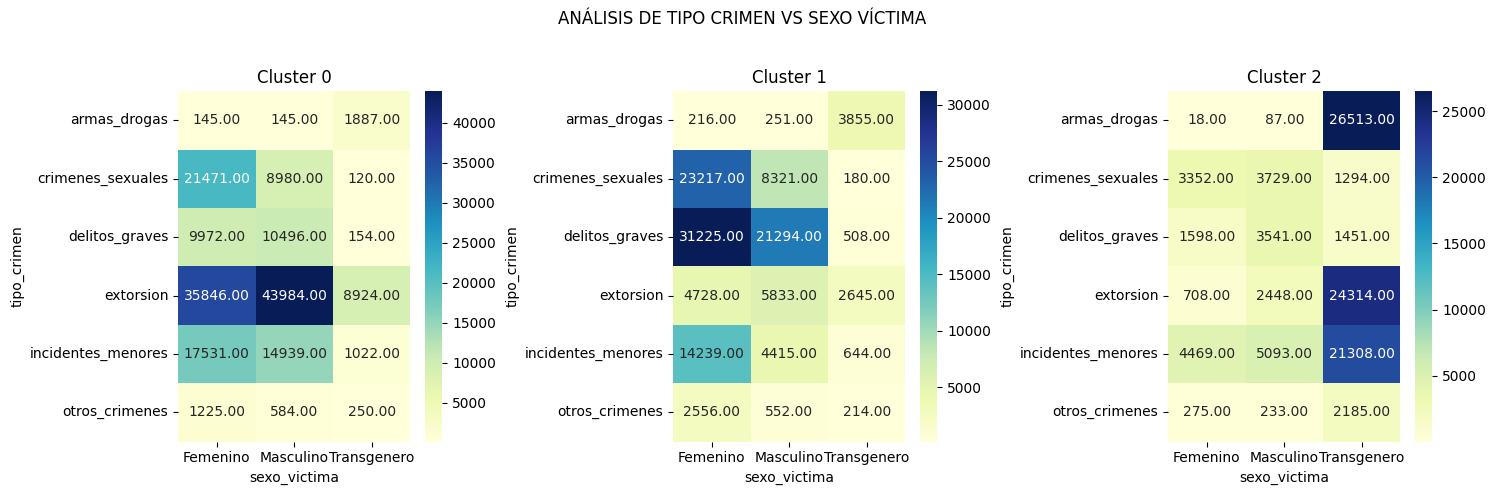

In [ ]:
bronx_cluster_kmodes0 = categoricas_bronx[categoricas_bronx['labels']==0]
bronx_cluster_kmodes1 = categoricas_bronx[categoricas_bronx['labels']==1]
bronx_cluster_kmodes2 = categoricas_bronx[categoricas_bronx['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['tipo_crimen'], bronx_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['tipo_crimen'], bronx_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['tipo_crimen'], bronx_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

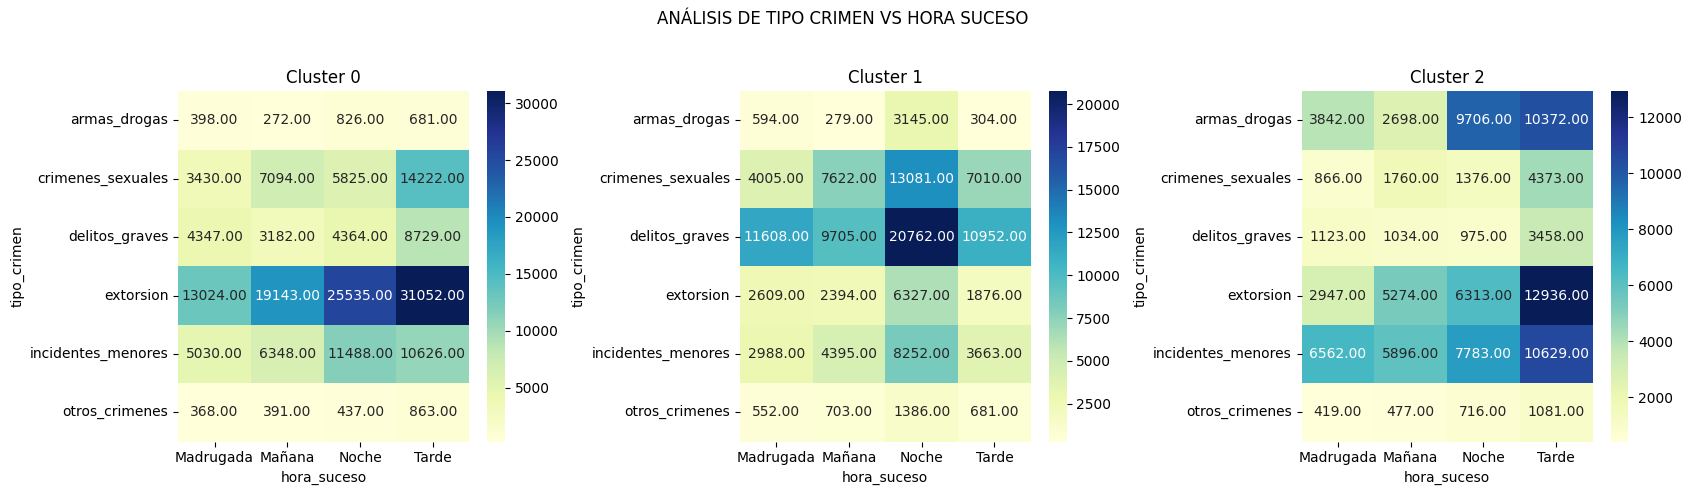

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['tipo_crimen'], bronx_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['tipo_crimen'], bronx_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['tipo_crimen'], bronx_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

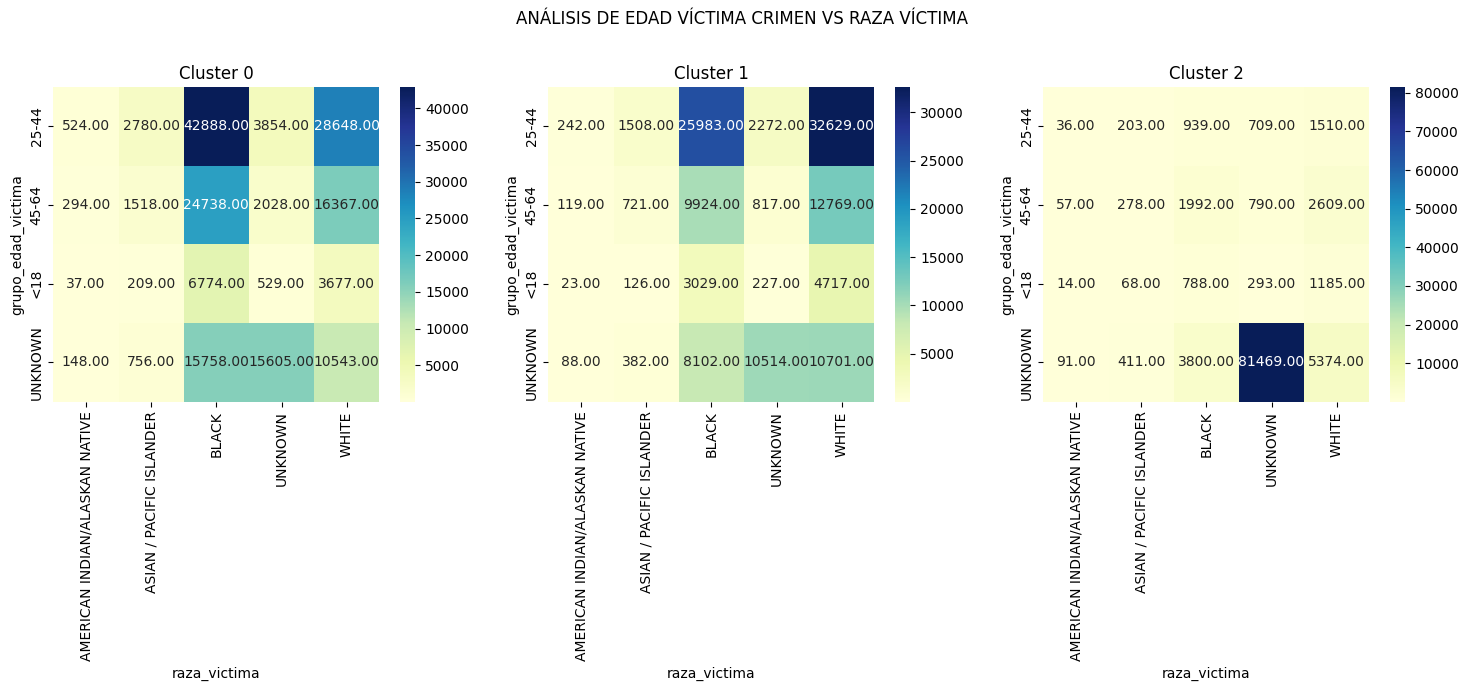

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['grupo_edad_victima'], bronx_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['grupo_edad_victima'], bronx_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['grupo_edad_victima'], bronx_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

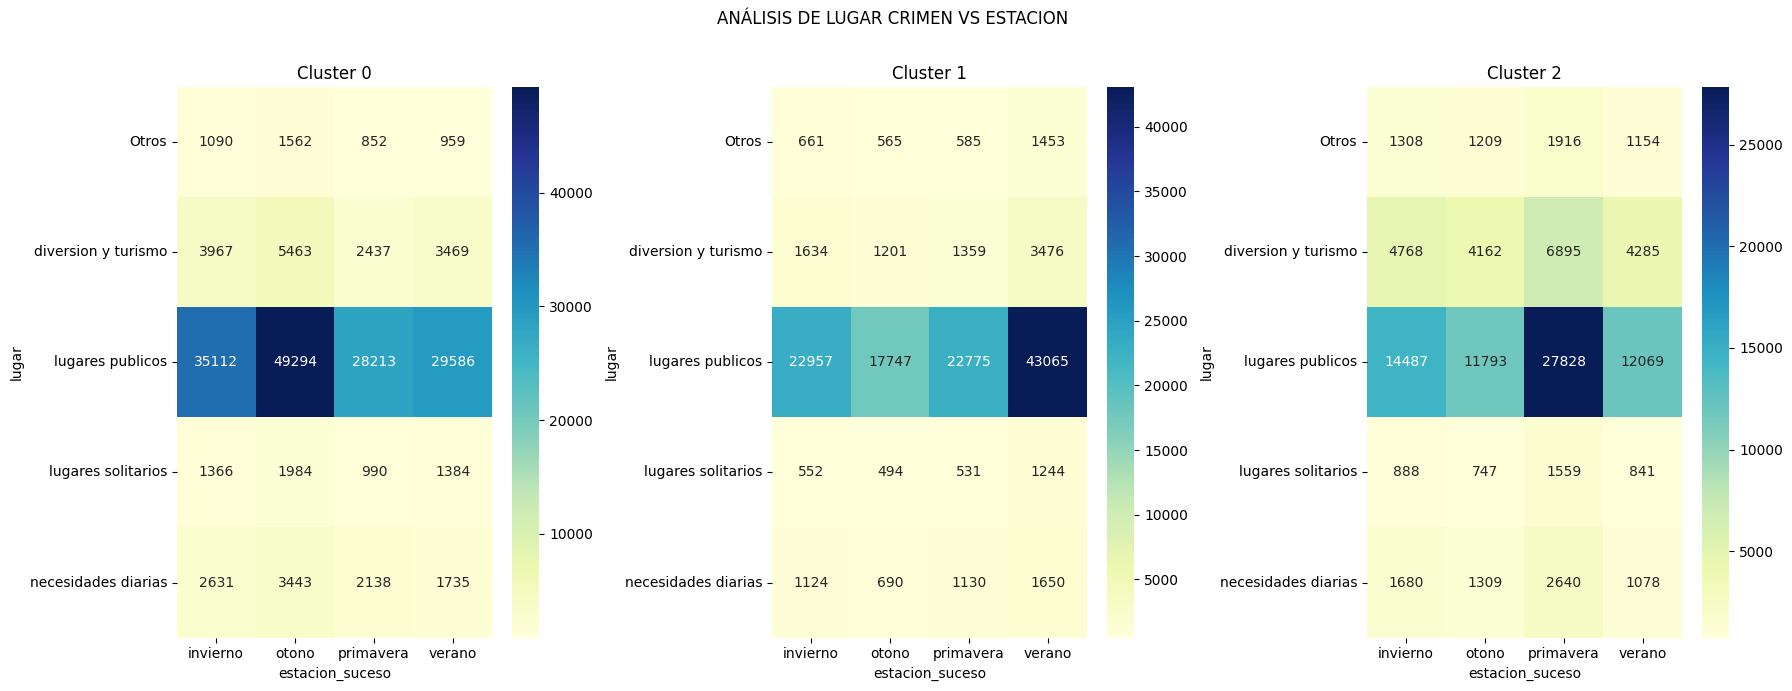

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['lugar'], bronx_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['lugar'], bronx_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['lugar'], bronx_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in categoricas_bronx.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    aux1 = categoricas_bronx.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'})
    aux2 = categoricas_bronx.groupby('labels').size().reset_index().rename(columns = {0:'casos_totales'})
    aux3 = aux1.merge(aux2,how='left', on = 'labels')
    aux3['participacion'] = aux3['casos']/aux3['casos_totales']
    aux3.drop(columns = ['casos_totales'], inplace = True)
    pd.options.display.float_format = '{:.1%}'.format 
    display(aux3)
    print('\n')
  pd.reset_option('display.float_format')

Variable hora_suceso:


,labels,hora_suceso,casos,participacion
0,0,Madrugada,26597,15.0%
1,0,Mañana,36430,20.5%
2,0,Noche,48475,27.3%
3,0,Tarde,66173,37.2%
4,1,Madrugada,22356,17.9%
5,1,Mañana,25098,20.1%
6,1,Noche,52953,42.4%
7,1,Tarde,24486,19.6%
8,2,Madrugada,15759,15.4%
9,2,Mañana,17139,16.7%




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos,participacion
0,0,25-44,11743,6.6%
1,0,45-64,7183,4.0%
2,0,<18,4067,2.3%
3,0,UNKNOWN,154682,87.1%
4,1,25-44,71594,57.3%
5,1,45-64,16775,13.4%
6,1,<18,6355,5.1%
7,1,UNKNOWN,30169,24.2%
8,2,25-44,28865,28.1%
9,2,45-64,14031,13.7%




Variable raza_sospechoso:


,labels,raza_sospechoso,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,156,0.1%
1,0,ASIAN / PACIFIC ISLANDER,721,0.4%
2,0,BLACK,32613,18.4%
3,0,UNKNOWN,129141,72.7%
4,0,WHITE,15044,8.5%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,323,0.3%
6,1,ASIAN / PACIFIC ISLANDER,1419,1.1%
7,1,BLACK,79929,64.0%
8,1,UNKNOWN,6345,5.1%
9,1,WHITE,36877,29.5%




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos,participacion
0,0,Desconocido,119432,67.2%
1,0,Femenino,24254,13.7%
2,0,Masculino,33989,19.1%
3,1,Desconocido,2724,2.2%
4,1,Femenino,26006,20.8%
5,1,Masculino,96163,77.0%
6,2,Desconocido,19433,18.9%
7,2,Femenino,14571,14.2%
8,2,Masculino,68612,66.9%




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos,participacion
0,0,25-44,78694,44.3%
1,0,45-64,44945,25.3%
2,0,<18,11226,6.3%
3,0,UNKNOWN,42810,24.1%
4,1,25-44,62634,50.2%
5,1,45-64,24350,19.5%
6,1,<18,8122,6.5%
7,1,UNKNOWN,29787,23.9%
8,2,25-44,3397,3.3%
9,2,45-64,5726,5.6%




Variable raza_victima:


,labels,raza_victima,casos,participacion
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1003,0.6%
1,0,ASIAN / PACIFIC ISLANDER,5263,3.0%
2,0,BLACK,90158,50.7%
3,0,UNKNOWN,22016,12.4%
4,0,WHITE,59235,33.3%
5,1,AMERICAN INDIAN/ALASKAN NATIVE,472,0.4%
6,1,ASIAN / PACIFIC ISLANDER,2737,2.2%
7,1,BLACK,47038,37.7%
8,1,UNKNOWN,13830,11.1%
9,1,WHITE,60816,48.7%




Variable sexo_victima:


,labels,sexo_victima,casos,participacion
0,0,Femenino,86190,48.5%
1,0,Masculino,79128,44.5%
2,0,Transgenero,12357,7.0%
3,1,Femenino,76181,61.0%
4,1,Masculino,40666,32.6%
5,1,Transgenero,8046,6.4%
6,2,Femenino,10420,10.2%
7,2,Masculino,15131,14.7%
8,2,Transgenero,77065,75.1%




Variable tipo_crimen:


,labels,tipo_crimen,casos,participacion
0,0,armas_drogas,2177,1.2%
1,0,crimenes_sexuales,30571,17.2%
2,0,delitos_graves,20622,11.6%
3,0,extorsion,88754,50.0%
4,0,incidentes_menores,33492,18.9%
5,0,otros_crimenes,2059,1.2%
6,1,armas_drogas,4322,3.5%
7,1,crimenes_sexuales,31718,25.4%
8,1,delitos_graves,53027,42.5%
9,1,extorsion,13206,10.6%




Variable lugar:


,labels,lugar,casos,participacion
0,0,Otros,4463,2.5%
1,0,diversion y turismo,15336,8.6%
2,0,lugares publicos,142205,80.0%
3,0,lugares solitarios,5724,3.2%
4,0,necesidades diarias,9947,5.6%
5,1,Otros,3264,2.6%
6,1,diversion y turismo,7670,6.1%
7,1,lugares publicos,106544,85.3%
8,1,lugares solitarios,2821,2.3%
9,1,necesidades diarias,4594,3.7%




Variable dia_suceso:


,labels,dia_suceso,casos,participacion
0,0,domingo,23658,13.3%
1,0,jueves,24837,14.0%
2,0,lunes,26127,14.7%
3,0,martes,22375,12.6%
4,0,miercoles,25611,14.4%
5,0,sabado,20870,11.7%
6,0,viernes,34197,19.2%
7,1,domingo,19086,15.3%
8,1,jueves,17033,13.6%
9,1,lunes,17518,14.0%




Variable estacion_suceso:


,labels,estacion_suceso,casos,participacion
0,0,invierno,44166,24.9%
1,0,otono,61746,34.8%
2,0,primavera,34630,19.5%
3,0,verano,37133,20.9%
4,1,invierno,26928,21.6%
5,1,otono,20697,16.6%
6,1,primavera,26380,21.1%
7,1,verano,50888,40.7%
8,2,invierno,23131,22.5%
9,2,otono,19220,18.7%




Variable mes_suceso:


,labels,mes_suceso,casos,participacion
0,0,abril,9692,5.5%
1,0,agosto,10796,6.1%
2,0,diciembre,40804,23.0%
3,0,febrero,13730,7.7%
4,0,julio,12860,7.2%
5,0,junio,12878,7.2%
6,0,marzo,12157,6.8%
7,0,mayo,12060,6.8%
8,0,noviembre,19694,11.1%
9,0,octubre,19527,11.0%
